In [79]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# def preprocess_barcode(image):
#     # Step 1: Denoise the image using Gaussian blur
#     denoised = cv2.GaussianBlur(image, (5, 5), 0)

#     # Step 2: Binarize the image (convert to black and white)
#     _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#     median_denoised = cv2.medianBlur(binary, 5)


#     # Step 3: Detect edges using Sobel filter
#     sobelx = cv2.Sobel(median_denoised, cv2.CV_64F, 1, 0, ksize=3)
#     sobelx = cv2.convertScaleAbs(sobelx)

#     # Step 4: Close gaps in the bars using morphological closing
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
#     closed = cv2.morphologyEx(sobelx, cv2.MORPH_CLOSE, kernel)

    
    
#     # Step 5: Find contours and crop the barcode region
#     contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     if contours:
#         largest_contour = max(contours, key=cv2.contourArea)
#         x, y, w, h = cv2.boundingRect(largest_contour)
#         cropped = binary[y:y + h, x:x + w]
#         # cropped = cv2.medianBlur(cropped, 5)
#     else:
#         cropped = binary  
        
#     # Step 5: Remove small artifacts using morphological opening
#     kernel_clean = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
#     cleaned = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_clean)


#     return binary, cleaned, cropped



def preprocess_barcode(image):
    # Step 1: Detect the finger (skin color) and mask it out
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_skin = np.array([0, 20, 70], dtype=np.uint8) 
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)
    skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)
    
    # Threshold the skin mask to remove the finger region
    _, binary_skin_mask = cv2.threshold(skin_mask, 127, 255, cv2.THRESH_BINARY_INV)
    
    # Mask the image to remove the finger region
    masked_image = cv2.bitwise_and(image, image, mask=binary_skin_mask)
    
    # Convert the masked image to grayscale
    gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    
    # Denoise the grayscale image using Gaussian blur
    denoised = cv2.GaussianBlur(gray_image, (5, 5), 0)
    
    # Binarize the image using Otsu's method
    _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Clean up the binary image
    median_denoised = cv2.medianBlur(binary, 5)
    
    # Detect edges using the Sobel filter
    sobelx = cv2.Sobel(median_denoised, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = cv2.convertScaleAbs(sobelx)
    
    # Close gaps in the barcode lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    closed = cv2.morphologyEx(sobelx, cv2.MORPH_CLOSE, kernel)
    
    # Remove small artifacts
    kernel_clean = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    cleaned = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_clean)
    
     # Find contours and crop the barcode region
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped = binary[y:y + h, x:x + w]
        # Get rotated bounding box
        rect = cv2.minAreaRect(largest_contour)
        box = cv2.boxPoints(rect)
        box = np.intp(box)

        # Ensure width is always greater than height
        width = int(max(rect[1]))
        height = int(min(rect[1]))

        # Correct perspective based on the box points
        src_pts = box.astype("float32")
        dst_pts = np.array([[0, 0], [width-1, 0], [width-1, height-1], [0, height-1]], dtype="float32")
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        cropped = cv2.warpPerspective(binary, M, (width, height))
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 185))
        cropped = cv2.morphologyEx(cropped, cv2.MORPH_CLOSE, vertical_kernel)
    else:
        cropped = binary
        


        
    
    # Step 3: Apply vertical closing to fill gaps in vertical lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 160))  # (width, height)
    vertical_closed = cv2.morphologyEx(cropped, cv2.MORPH_CLOSE, vertical_kernel)
    
    return binary, cleaned, vertical_closed






In [81]:
def adjust_orientation(image, horizontal_threshold=5):
    # Detect edges using Canny edge detector
    edges = cv2.Canny(image, 50, 150)
    
    # Perform Hough Line Transform to detect lines
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 150)
    
    if lines is not None:
        # Calculate the average angle of the detected lines
        angles = []
        for rho, theta in lines[:, 0]:
            angles.append(theta)
        
        # Convert from radians to degrees
        avg_angle = np.mean(angles) * 180 / np.pi
        
        # Determine the angle to rotate
        if avg_angle > 90:
            angle_to_rotate = avg_angle - 180
        else:
            angle_to_rotate = avg_angle
        
        # Check if the angle is within the horizontal threshold
        if abs(angle_to_rotate) < horizontal_threshold:
            # If the angle is already nearly horizontal, return the original image
            return image
        
        # Otherwise, rotate the image to make it horizontal
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle_to_rotate, 1.0)
        rotated = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
        
        return rotated
    else:
        # If no lines are detected, return the original image
        return image




In [82]:
def remove_wave_noise(image):
    # Step 2: Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Step 2.1: Analyze intensity histogram to detect noise
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist_variance = np.var(hist)  # Variance of histogram values
    
    # Perform frequency domain filtering only if histogram variance is high
    if hist_variance > 5000:  # Adjust this threshold based on test cases
        # Apply Discrete Fourier Transform (DFT)
        dft = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
        dft_shift = np.fft.fftshift(dft)

        # Compute the magnitude spectrum
        magnitude = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

        # Create a notch filter to suppress noise frequencies
        rows, cols = gray.shape
        crow, ccol = rows // 2, cols // 2
        mask = np.ones((rows, cols, 2), np.uint8)
        mask[crow-30:crow+30, ccol-30:ccol+30] = 0  # Suppress center frequencies

        # Apply the mask and perform inverse Fourier Transform
        fshift = dft_shift * mask
        f_ishift = np.fft.ifftshift(fshift)
        filtered = cv2.idft(f_ishift)
        filtered = cv2.magnitude(filtered[:, :, 0], filtered[:, :, 1])

        # Normalize the result back to 8-bit range
        filtered = cv2.normalize(filtered, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        return filtered
    else:
        return gray  # If no wave noise, use the original image

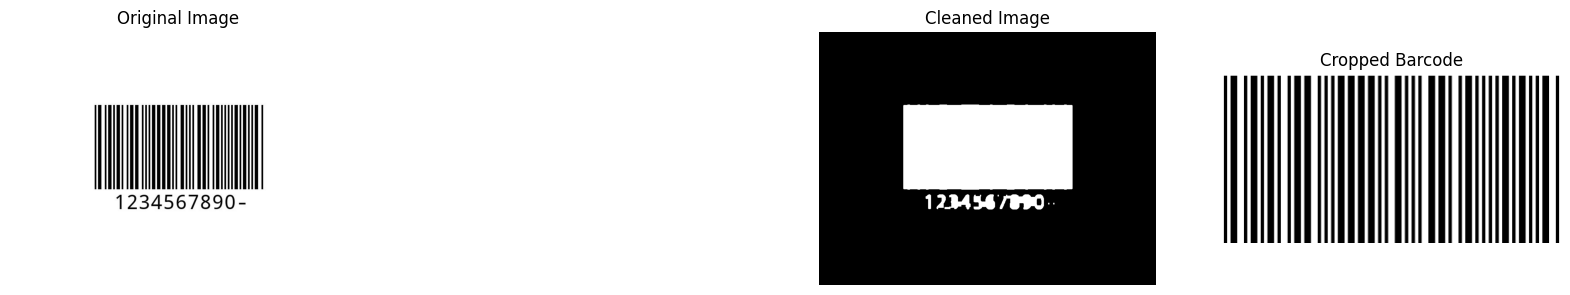

In [83]:
image_path = "Test Cases\\01 - lol easy.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, cleaned, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")



# Cleaned Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(cleaned, cmap='gray')
plt.title("Cleaned Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

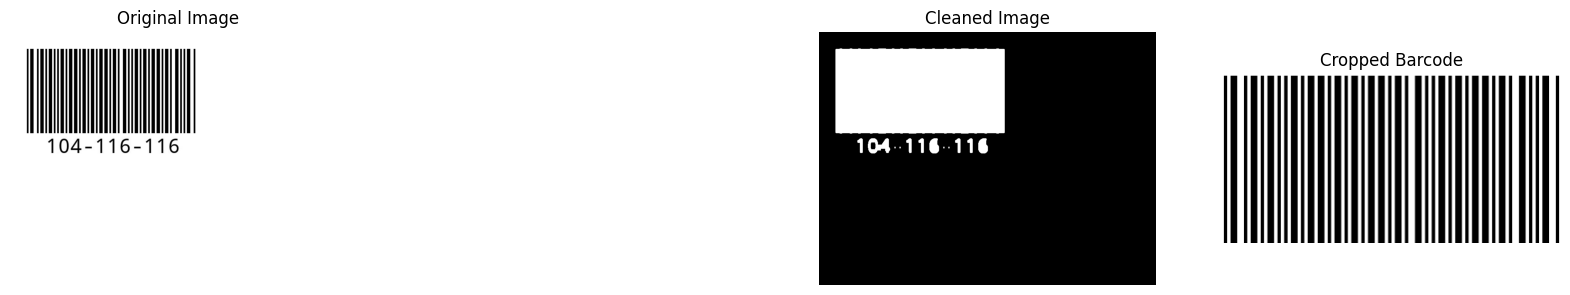

In [84]:
image_path = "Test Cases\\02 - still easy.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, cleaned, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")



# Cleaned Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(cleaned, cmap='gray')
plt.title("Cleaned Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

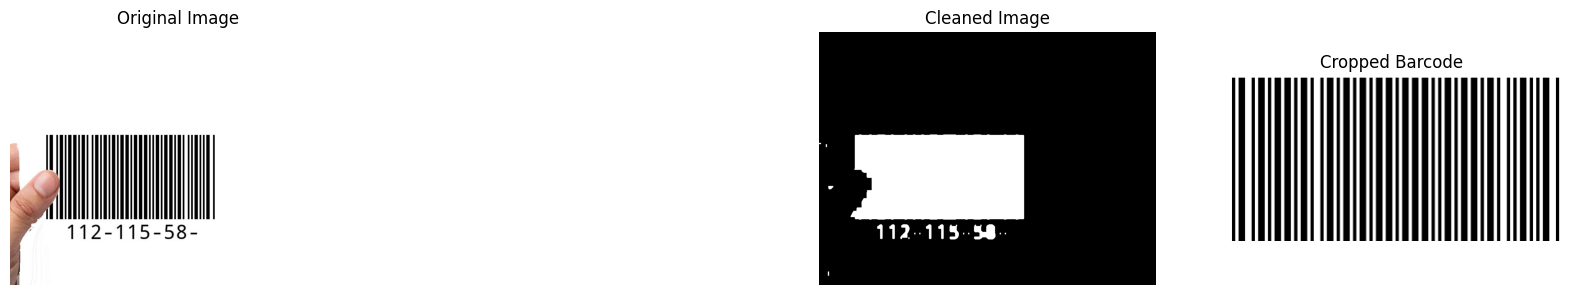

In [85]:
image_path = "Test Cases\\03 - eda ya3am ew3a soba3ak mathazarsh.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, cleaned, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")



# Cleaned Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(cleaned, cmap='gray')
plt.title("Cleaned Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

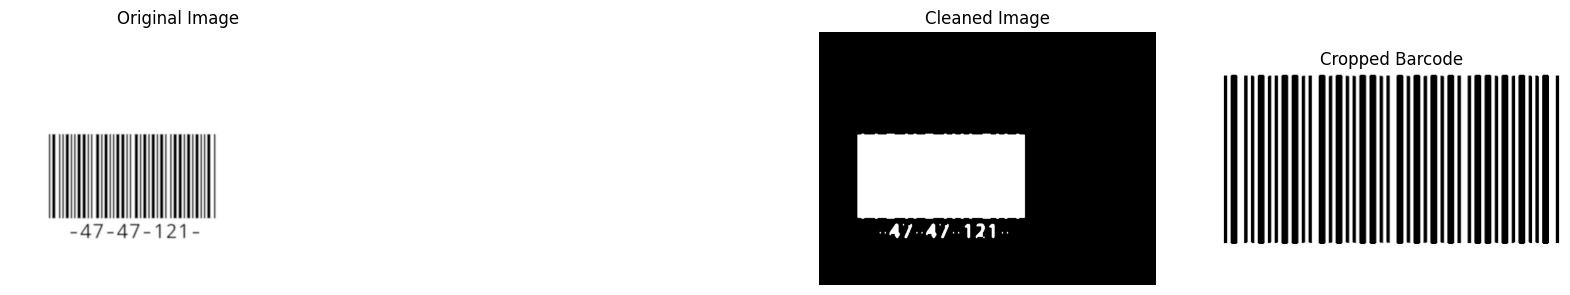

In [86]:
image_path = "Test Cases\\04 - fen el nadara.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, cleaned, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")



# Cleaned Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(cleaned, cmap='gray')
plt.title("Cleaned Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

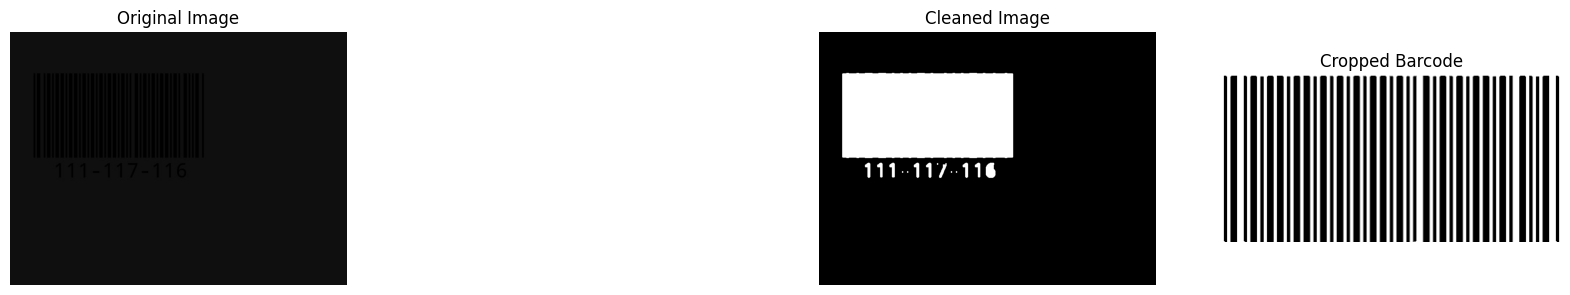

In [87]:
image_path = "Test Cases\\05 - meen taffa el nour!!!.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, cleaned, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")



# Cleaned Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(cleaned, cmap='gray')
plt.title("Cleaned Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

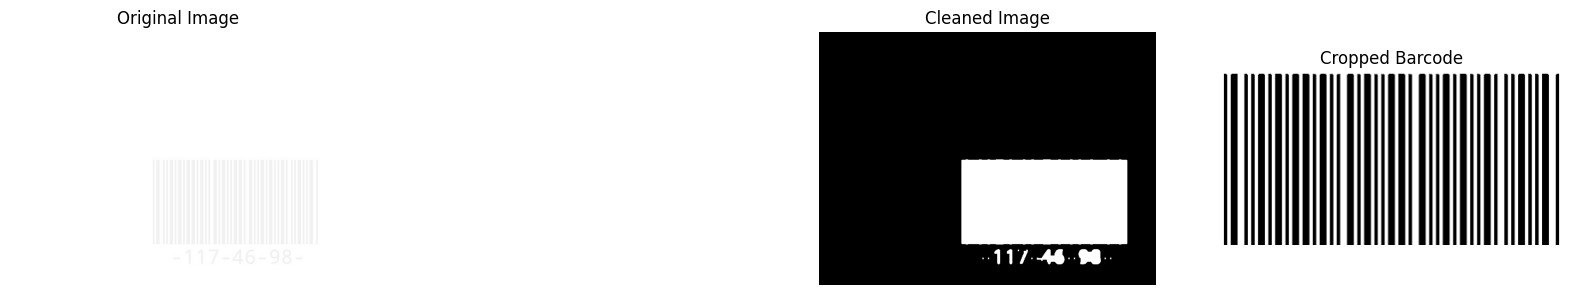

In [88]:
image_path = "Test Cases\\06 - meen fata7 el nour 333eenaaayy.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, cleaned, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")



# Cleaned Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(cleaned, cmap='gray')
plt.title("Cleaned Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

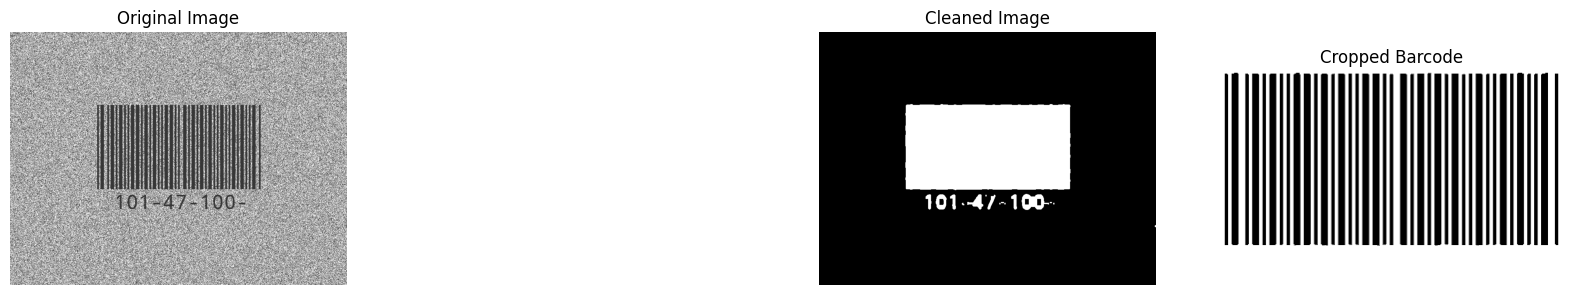

In [89]:
image_path = "Test Cases\\07 - mal7 w felfel.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, cleaned, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")



# Cleaned Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(cleaned, cmap='gray')
plt.title("Cleaned Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

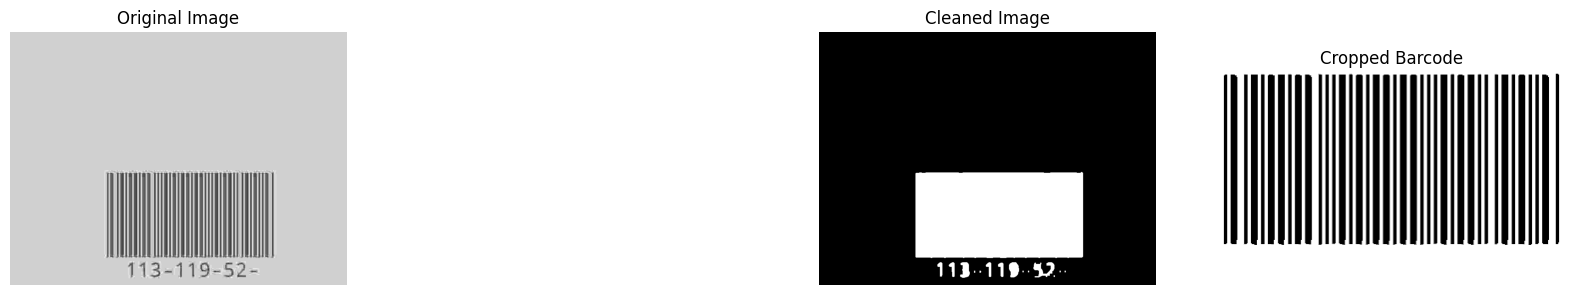

In [90]:
image_path = "Test Cases\\08 - compresso espresso.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, cleaned, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")



# Cleaned Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(cleaned, cmap='gray')
plt.title("Cleaned Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

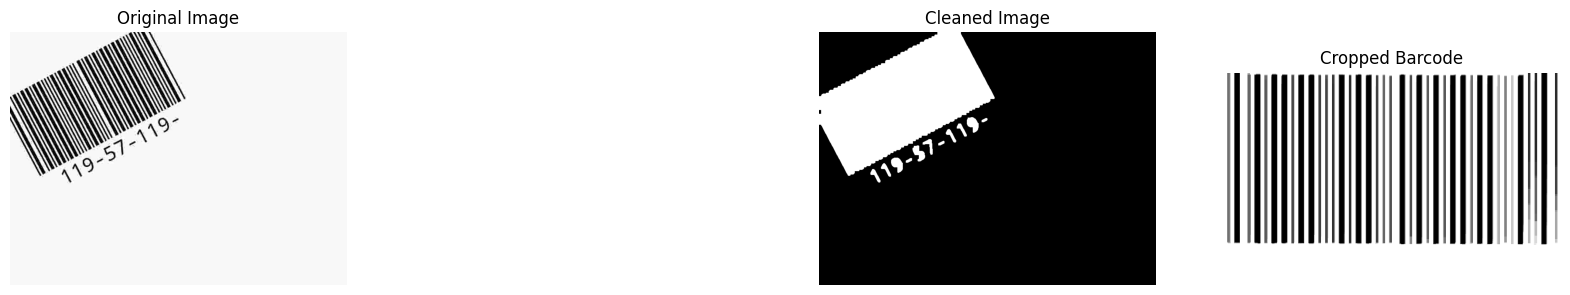

In [91]:
image_path = "Test Cases\\09 - e3del el soora ya3ammm.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, cleaned, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")



# Cleaned Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(cleaned, cmap='gray')
plt.title("Cleaned Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

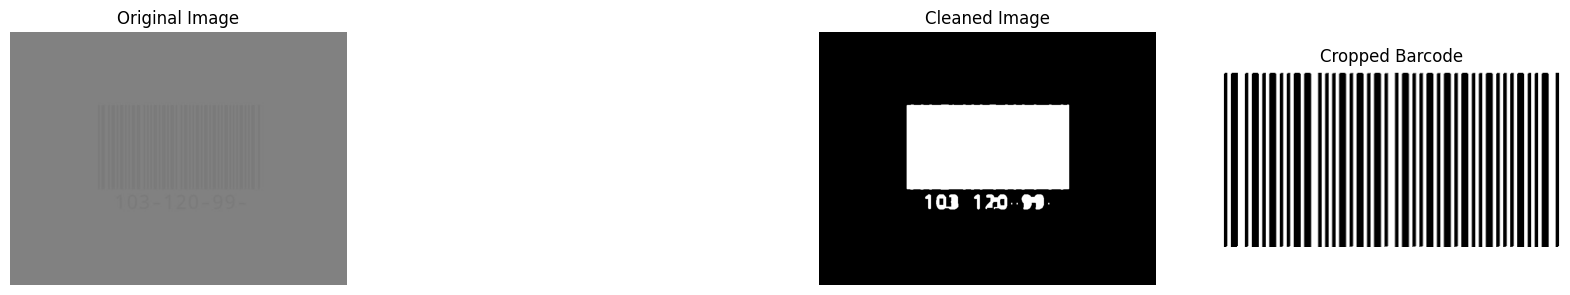

In [92]:
image_path = "Test Cases\\10 - wen el kontraastttt.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, cleaned, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")



# Cleaned Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(cleaned, cmap='gray')
plt.title("Cleaned Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()

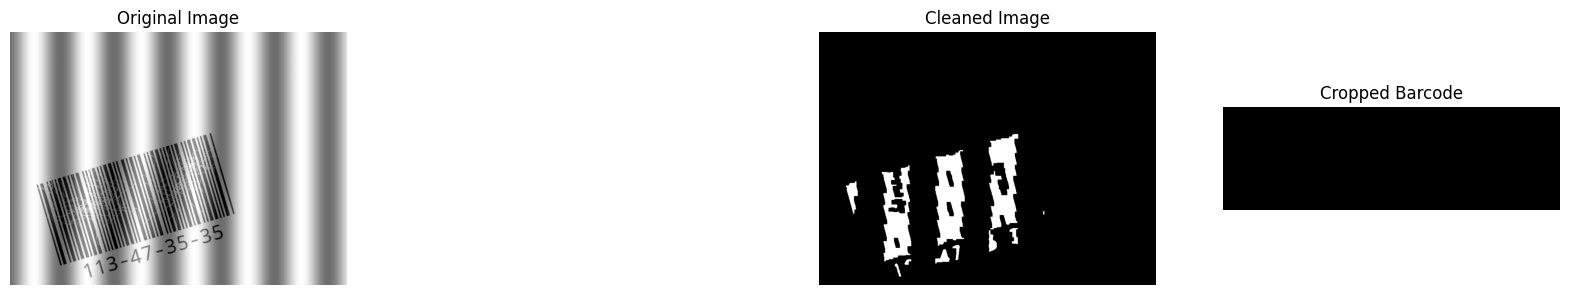

In [93]:
image_path = "Test Cases\\11 - bayza 5ales di bsara7a.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, cleaned, cropped = preprocess_barcode(image)

# Visualize the results
plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")



# Cleaned Image (After Morphological Processing)
plt.subplot(1, 4, 3)
plt.imshow(cleaned, cmap='gray')
plt.title("Cleaned Image")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")

plt.show()